<a href="https://colab.research.google.com/github/ajavid34/guided-diffusion-sxela/blob/main/fine_tuning_openai_diffusion_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

A simple colab to fine-tune openai diffusion models.


Feel free to ask questions in this post's comments: https://www.patreon.com/posts/66246423

by [Alex Spirin](https://twitter.com/devdef)

![visitors](https://visitor-badge.glitch.me/badge?page_id=sxela_finetune_openai_colab)

## Setup (run once per session)

This mounts your google drive for easier storage

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


This downloads the training code and installs it

In [2]:
%cd /content
!git clone https://github.com/ajavid34/guided-diffusion-sxela
%cd /content/guided-diffusion-sxela
!pip install -e .

/content
Cloning into 'guided-diffusion-sxela'...
remote: Enumerating objects: 176, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 176 (delta 11), reused 3 (delta 3), pack-reused 156 (from 2)
Receiving objects: 100% (176/176), 137.94 KiB | 1.84 MiB/s, done.
Resolving deltas: 100% (89/89), done.
/content/guided-diffusion-sxela
Obtaining file:///content/guided-diffusion-sxela
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 109.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 98.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

#Train (tune) BEDROOM model :D
Needs 16gb GPU RAM

Works in colab pro and on kaggle

Download a pre-trained LSUN BEDROOM model that we will be tuning on our dataset

In [3]:
!wget https://openaipublic.blob.core.windows.net/diffusion/jul-2021/256x256_diffusion.pt -P /content/

--2025-05-29 01:59:48--  https://openaipublic.blob.core.windows.net/diffusion/jul-2021/256x256_diffusion.pt
Resolving openaipublic.blob.core.windows.net (openaipublic.blob.core.windows.net)... 57.150.97.129
Connecting to openaipublic.blob.core.windows.net (openaipublic.blob.core.windows.net)|57.150.97.129|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2215479544 (2.1G) [application/octet-stream]
Saving to: ‘/content/256x256_diffusion.pt’

256x256_diffusion.p 100%[===================>]   2.06G  23.8MB/s    in 98s     

2025-05-29 02:01:26 (21.5 MB/s) - ‘/content/256x256_diffusion.pt’ saved [2215479544/2215479544]



In [4]:
!echo "Downloading and preparing dataset..."
!# Download Oxford 102 flowers dataset
!wget https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz

# Extract and organize images
!tar -xzf 102flowers.tgz
!mkdir -p your_images
!cp jpg/*.jpg your_images/

--2025-05-29 02:01:27--  https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/flowers/102/102flowers.tgz [following]
--2025-05-29 02:01:27--  https://thor.robots.ox.ac.uk/flowers/102/102flowers.tgz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 344862509 (329M) [application/octet-stream]
Saving to: ‘102flowers.tgz’

102flowers.tgz      100%[===================>] 328.89M  30.9MB/s    in 11s     

2025-05-29 02:01:39 (28.8 MB/s) - ‘102flowers.tgz’ saved [344862509/344862509]



## Tune

For gigachads.
We're going to do what's called a pro-gamer move (or not): tune a small model, trained on bedrooms, on our own dataset. Just because we can and it's much faster than training from scratch.

Don't forget to change the paths:
You need to change DATASET_PATH to point to your dataset images folder, and CHECKPOINT_PATH - to point to a folder you'd like to save progress to.

For, example here /content/drive/MyDrive/deep_learning/guided-diffusion-sxela/ - this path points to a location, where all the training checkpoints will be saved

and /content/YourDatasetHere/ - this path points to your dataset, i.e. a folder with images (no captions needed)




We will be using this model together with CLIP inside DiscoDiffusion, so we can train less, stop early and let CLIP do the heavy lifting.

This will run almost forever, but you should start checking your results at around ~50k iterations. Good results begin to appear at 100-200k iterations, depending on your dataset.

Validating means opening your CHECKPOINT_PATH folder, taking the ema_0.9999_(some number of steps).pt file with the highest number (the latest one), going to this version of DiscoDiffusion here
https://github.com/Sxela/DiscoDiffusion-Warp/blob/main/Disco_Diffusion_v5_2_Warp_custom_model.ipynb and setting this: diffusion-model - custom, custom_path - path to that ema file from the previous step (if you saved it on google drive - then just point it there), and set width_height to 256x256, then run DD as usual


In [8]:
MODEL_FLAGS="--image_size 256 --num_channels 128 --num_res_blocks 2 --num_heads 1 --learn_sigma True --use_scale_shift_norm False --attention_resolutions 16"
DIFFUSION_FLAGS="--diffusion_steps 1000 --noise_schedule linear --rescale_learned_sigmas False --rescale_timesteps False --use_scale_shift_norm False"
TRAIN_FLAGS="--lr 2e-5 --batch_size 4 --save_interval 2000 --log_interval 50 --resume_checkpoint /content/lsun_uncond_100M_1200K_bs128.pt"
DATASET_PATH="./your_images/" #change to point to your dataset path
OUTPUT_PATH="/content/drive/MyDrive/deep_learning/guided-diffusion-sxela/" #models will be saved here, change to your drive folder or else
%cd /content/guided-diffusion-sxela
!python scripts/image_train.py --data_dir $DATASET_PATH $MODEL_FLAGS $DIFFUSION_FLAGS $TRAIN_FLAGS --logdir $OUTPUT_PATH

#if you are using vanilla openai repo, then you will ned to run this:
#!OPENAI_LOGDIR=$OUTPUT_PATH python scripts/image_train.py --data_dir $DATASET_PATH $MODEL_FLAGS $DIFFUSION_FLAGS $TRAIN_FLAGS

/content/guided-diffusion-sxela
/content/guided-diffusion-sxela/guided_diffusion/nn.py:143: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @th.cuda.amp.custom_fwd
/content/guided-diffusion-sxela/guided_diffusion/nn.py:153: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  @th.cuda.amp.custom_bwd
set output to  /content/drive/MyDrive/deep_learning/guided-diffusion-sxela/
Logging to /content/drive/MyDrive/deep_learning/guided-diffusion-sxela/
creating model and diffusion...
creating data loader...
training...
loading model from checkpoint: /content/lsun_uncond_100M_1200K_bs128.pt...
-------------------------
| grad_norm  | 0.0195   |
| loss       | 0.00481  |
| loss_q1    | 0.00847  |
| loss_q2    | 0.00115  |
| mse        | 0.00477  |
| mse_q1     | 0.00841  |
| mse_q2     | 0.00114  |
| param_norm | 683 

In [6]:
# Set explicit output directory
OUTPUT_DIR="/content/classifier_ect_models"
!mkdir -p $OUTPUT_DIR

# Classifier architecture flags
CLASSIFIER_FLAGS="--image_size 256 --classifier_attention_resolutions 32,16,8 --classifier_depth 2 --classifier_width 128 --classifier_pool attention --classifier_use_fp16 True"

# Training flags - quick run to test saving
TRAIN_FLAGS="--lr 1e-4 --batch_size 32 --save_interval 200 --log_interval 100 --iterations 3000 --anneal_lr True --weight_decay 0.05"

# ECT flags
ECT_FLAGS="--ect_weight 0.1 --ect_divergence JS --mi_weight 0.01 --mi_divergence JS"

# Entropy configuration flags
ENTROPY_FLAGS="--entropy_type renyi --entropy_alpha 2.0"

# Dataset path
DATASET_PATH="./your_images/"

# Run training with explicit logging directory
%cd /content/guided-diffusion-sxela
!OPENAI_LOGDIR=$OUTPUT_DIR python scripts/classifier_train.py \
    --data_dir $DATASET_PATH \
    --noised True \
    $CLASSIFIER_FLAGS \
    $TRAIN_FLAGS \
    $ECT_FLAGS \
    $ENTROPY_FLAGS

/content/guided-diffusion-sxela
/content/guided-diffusion-sxela/guided_diffusion/nn.py:143: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @th.cuda.amp.custom_fwd
/content/guided-diffusion-sxela/guided_diffusion/nn.py:153: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  @th.cuda.amp.custom_bwd
Logging to /content/classifier_ect_models
creating model and diffusion...
creating data loader...
creating optimizer...
training classifier model with ECT...
Found NaN, decreased lg_loss_scale to 15.0
--------------------------------
| lg_loss_scale    | 16        |
| samples          | 32        |
| step             | 0         |
| train_acc@1      | 0         |
| train_acc@1_q0   | 0         |
| train_acc@1_q1   | 0         |
| train_acc@1_q2   | 0         |
| train_acc@1_q3   | 0         |
| train_acc@5      |

In [12]:
# Check saved files
OUTPUT_DIR="/content/classifier_ect_models"
!ls -la $OUTPUT_DIR/

total 9510024
drwxr-xr-x 2 root root      4096 May 29 02:22 .
drwxr-xr-x 1 root root      4096 May 29 02:05 ..
-rw-r--r-- 1 root root     26714 May 29 02:22 log.txt
-rw-r--r-- 1 root root 216436528 May 29 02:06 model000200.pt
-rw-r--r-- 1 root root 216436528 May 29 02:07 model000400.pt
-rw-r--r-- 1 root root 216436528 May 29 02:08 model000600.pt
-rw-r--r-- 1 root root 216436528 May 29 02:10 model000800.pt
-rw-r--r-- 1 root root 216436528 May 29 02:11 model001000.pt
-rw-r--r-- 1 root root 216436528 May 29 02:12 model001200.pt
-rw-r--r-- 1 root root 216436528 May 29 02:13 model001400.pt
-rw-r--r-- 1 root root 216436528 May 29 02:14 model001600.pt
-rw-r--r-- 1 root root 216436528 May 29 02:15 model001800.pt
-rw-r--r-- 1 root root 216436528 May 29 02:16 model002000.pt
-rw-r--r-- 1 root root 216436528 May 29 02:18 model002200.pt
-rw-r--r-- 1 root root 216436528 May 29 02:19 model002400.pt
-rw-r--r-- 1 root root 216436528 May 29 02:20 model002600.pt
-rw-r--r-- 1 root root 216436528 May 29 02

In [5]:
!pip install mpi4py

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 466.3/466.3 kB 8.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for mpi4py: filename=mpi4py-4.0.3-cp311-cp311-linux_x86_64.whl size=4441920 sha256=8aaf6c2d0e83bf4056e29cccf9f706baf78b4e3f12066a4f2b0af662f9365be5
  Stored in directory: /root/.cache/pip/wheels/5c/56/17/bf6ba37aa971a191a8b9eaa188bf5ec855b8911c1c56fb1f84
Successfully built mpi4py


## Sampling
The best way to sample your model in real-life conditions is to plug it into DiscoDiffusion.


Grab your latest ema checkpoint, open this colab here - https://github.com/Sxela/DiscoDiffusion-Warp/blob/main/Disco_Diffusion_v5_2_Warp_custom_model.ipynb

and change model settings > custom model path to your ema checkpoint's location, as described in the previous cell.

You can still sample using vanilla openai code, just plug your checkpoint in the cell below

Don't forget to change all the paths

In [ ]:
checkpoint_path = 'input some checkpoint path here' #use ema checkpoint
OUTPUT_PATH="/content/drive/MyDrive/deep_learning/guided-diffusion-sxela/"
!python scripts/image_sample.py --num_samples 1 --model_path $checkpoint_path $MODEL_FLAGS $DIFFUSION_FLAGS --timestep_respacing ddim100 --logdir $OUTPUT_PATH

#if you are using vanilla openai repo, then you will ned to run this:
#!OPENAI_LOGDIR=/content/drive/MyDrive/deep_learning/guided-diffusion-sxela/samples/  python scripts/image_sample.py --num_samples 1 --model_path $checkpoint_path $MODEL_FLAGS $DIFFUSION_FLAGS --timestep_respacing ddim100

In [16]:

# Use the correct paths
DIFFUSION_MODEL_PATH="/content/256x256_diffusion.pt"  # Your unconditional diffusion model
CLASSIFIER_PATH="/content/classifier_ect_models/model002999.pt"  # Replace with actual saved classifier

# Run sampling with unconditional diffusion model
!python scripts/classifier_sample.py \
    --attention_resolutions 32,16,8 \
    --class_cond True \
    --diffusion_steps 3000 \
    --image_size 256 \
    --learn_sigma True \
    --noise_schedule linear \
    --num_channels 256 \
    --num_head_channels 64 \
    --num_res_blocks 2 \
    --resblock_updown True \
    --use_fp16 True \
    --use_scale_shift_norm True \
    --model_path $DIFFUSION_MODEL_PATH \
    --classifier_attention_resolutions 32,16,8 \
    --classifier_depth 2 \
    --classifier_width 128 \
    --classifier_pool attention \
    --classifier_resblock_updown True \
    --classifier_use_scale_shift_norm True \
    --classifier_use_fp16 True \
    --classifier_path $CLASSIFIER_PATH \
    --batch_size 32 \
    --num_samples 8 \
    --timestep_respacing 1000 \
    --classifier_scale 1.0 \
    --use_eds True \
    --entropy_type renyi \
    --entropy_alpha 2.0 \
    --entropy_weight 1.0 \
    --clip_denoised True

/content/guided-diffusion-sxela/guided_diffusion/nn.py:143: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @th.cuda.amp.custom_fwd
/content/guided-diffusion-sxela/guided_diffusion/nn.py:153: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  @th.cuda.amp.custom_bwd
Logging to /tmp/openai-2025-05-29-02-33-13-946820
creating model and diffusion...
loading classifier...
sampling with Entropy-Driven Sampling...
Using DDPM sampling
100% 1000/1000 [18:42<00:00,  1.12s/it]
created 32 samples
saving to /tmp/openai-2025-05-29-02-33-13-946820/samples_8x256x256x3_eds_renyi_alpha2.0_gamma1.0.npz
sampling complete
[rank0]:[W529 02:52:10.383684131 ProcessGroupNCCL.cpp:1496] Warning: WARNING: destroy_process_group() was not called before program exit, which can leak resources. For more info, please see https://pytorch.o

Generated 8 samples
Sample shape: (8, 256, 256, 3)
Labels: [396 795 364 884 953 724 426 477]


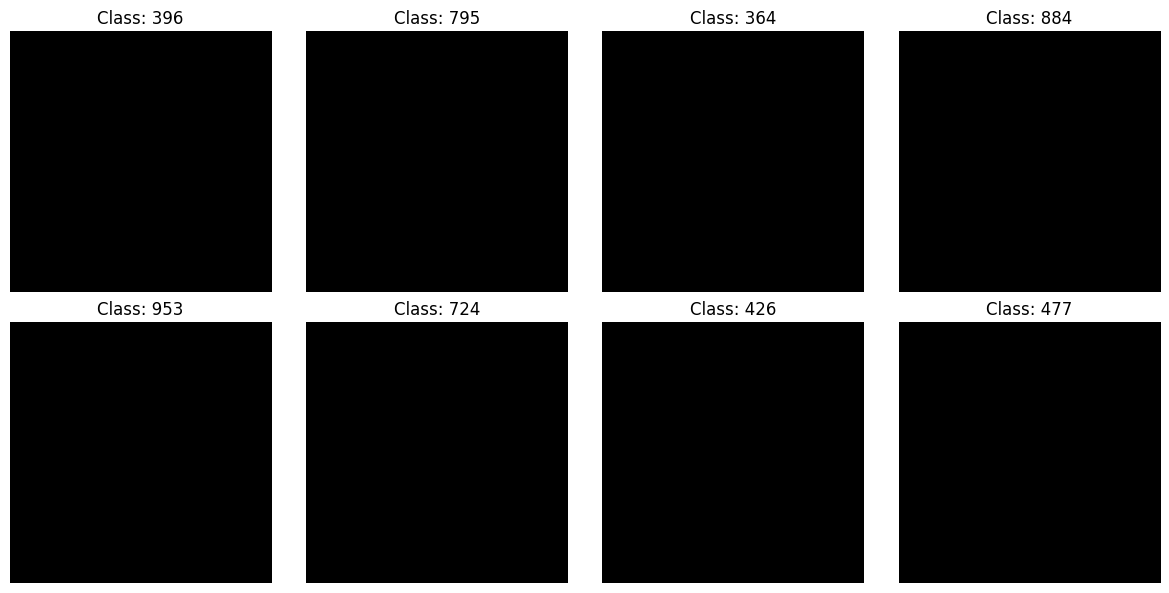

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

# Load the generated samples
sample_path = "/tmp/openai-2025-05-29-02-33-13-946820/samples_8x256x256x3_eds_renyi_alpha2.0_gamma1.0.npz"
data = np.load(sample_path)
samples = data['arr_0']  # Images
labels = data['arr_1']   # Class labels

print(f"Generated {samples.shape[0]} samples")
print(f"Sample shape: {samples.shape}")
print(f"Labels: {labels}")

# Visualize the samples
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.flatten()

for i in range(min(8, samples.shape[0])):
    axes[i].imshow(samples[i])
    axes[i].set_title(f"Class: {labels[i]}")
    axes[i].axis('off')

plt.tight_layout()
plt.savefig('/content/eds_samples.png', dpi=150, bbox_inches='tight')
plt.show()

# Save individual images
os.makedirs('/content/eds_samples', exist_ok=True)
for i in range(samples.shape[0]):
    img = Image.fromarray(samples[i])
    img.save(f'/content/eds_samples/sample_{i}_class_{labels[i]}.png')

In [22]:
len(samples)

8

In [ ]:
import numpy as np
import PIL

sample_path = 'some sample path'
im = np.load(sample_path)
PIL.Image.fromarray(im.f.arr_0[0])

#Train (tune) 256x256 vanilla DD model
Only if you have a beefy GPU with more than 16gb RAM

For lvl 50 AI bosses,
Will not fit into colab pro, only in colab pro+ with A100 gpu


Download a pre-trained openai 256x256 model (the one used in DiscoDiffusion) that we will be tuning on our dataset

In [ ]:
#download model checkpoint
!wget https://openaipublic.blob.core.windows.net/diffusion/jul-2021/256x256_diffusion_uncond.pt -P /content/
#if you wish to tune the 512x512 finetuned model from DD, you need to download it and change image size and checkpoint path later here:
#!wget https://huggingface.co/lowlevelware/512x512_diffusion_unconditional_ImageNet/resolve/main/512x512_diffusion_uncond_finetune_008100.pt

## Tune

Don't forget to change the paths:
You need to change DATASET_PATH to point to your dataset images folder, and CHECKPOINT_PATH - to point to a folder you'd like to save progress to.

For, example here /content/drive/MyDrive/deep_learning/guided-diffusion-sxela/ - this path points to a location, where all the training checkpoints will be saved

and /content/YourDatasetHere/ - this path points to your dataset, i.e. a folder with images (no captions needed)




We will be using this model together with CLIP inside DiscoDiffusion, so we can train less, stop early and let CLIP do the heavy lifting.

This will run almost forever, but you should start checking your results at around ~50k iterations. Good results begin to appear at 100-200k iterations, depending on your dataset.

Validating means opening your CHECKPOINT_PATH folder, taking the ema_0.9999_(some number of steps).pt file with the highest number (the latest one), going to this version of DiscoDiffusion here
https://github.com/Sxela/DiscoDiffusion-Warp/blob/main/Disco_Diffusion_v5_2_Warp_custom_model.ipynb and setting this: diffusion-model - custom, custom_path - path to that ema file from the previous step (if you saved it on google drive - then just point it there),

you'll need to set custom model settings to this:

    model_config.update({
        'attention_resolutions': '32, 16, 8',
        'class_cond': False,
        'diffusion_steps': diffusion_steps,
        'rescale_timesteps': True,
        'timestep_respacing': timestep_respacing,
        'image_size': 256,
        'learn_sigma': True,
        'noise_schedule': 'linear',
        'num_channels': 256,
        'num_head_channels': 64,
        'num_res_blocks': 2,
        'resblock_updown': True,
        'use_checkpoint': use_checkpoint,
        'use_fp16': True,
        'use_scale_shift_norm': True,
    })

In [ ]:
MODEL_FLAGS="--attention_resolutions 32,16,8 --class_cond False --diffusion_steps 1000 --image_size 256 --learn_sigma True --noise_schedule linear --num_channels 256 --num_head_channels 64  --num_res_blocks 2 --resblock_updown True --use_fp16 True --use_scale_shift_norm True"
TRAIN_FLAGS="--lr 2e-5 --batch_size 4 --save_interval 1000 --log_interval 50 --resume_checkpoint /content/256x256_diffusion_uncond.pt"
DATASET_PATH="/content/YourDatasetHere/" #change to point to your dataset path
OUTPUT_PATH="/content/drive/MyDrive/deep_learning/guided-diffusion/"
%cd /content/guided-diffusion
!python scripts/image_train.py --data_dir $DATASET_PATH $MODEL_FLAGS $TRAIN_FLAGS --logdir $OUTPUT_PATH

#if you are using vanilla openai repo, then you will ned to run this:
# !OPENAI_LOGDIR=$OUTPUT_PATH python scripts/image_train.py --data_dir $DATASET_PATH $MODEL_FLAGS $TRAIN_FLAGS

Sample from model

## Sampling
The best way to sample your model in real-life conditions is to plug it into DiscoDiffusion.


Grab your latest ema checkpoint, open this colab here - https://github.com/Sxela/DiscoDiffusion-Warp/blob/main/Disco_Diffusion_v5_2_Warp_custom_model.ipynb

and change settings like described in the previous cell

You can still sample using vanilla openai code, just plug your checkpoint in the cell below

Don't forget to change all the paths

In [ ]:
checkpoint_path = 'input some checkpoint path here' #use ema checkpoint
OUTPUT_PATH="/content/drive/MyDrive/deep_learning/guided-diffusion-sxela/"
!python scripts/image_sample.py --num_samples 1 --model_path $checkpoint_path $MODEL_FLAGS --timestep_respacing ddim100 --logdir $OUTPUT_PATH

#if you are using vanilla openai repo, then you will ned to run this:
#!OPENAI_LOGDIR=/content/drive/MyDrive/deep_learning/guided-diffusion-sxela/samples/  python scripts/image_sample.py --num_samples 1 --model_path $checkpoint_path $MODEL_FLAGS --timestep_respacing ddim100

Show results

In [ ]:
import numpy as np
import PIL

sample_path = 'some sample path'
im = np.load(sample_path)
PIL.Image.fromarray(im.f.arr_0[0])

# Train from scratch (smaller model than vanilla DD, but larger than LSUN)
For lvl 1 AI crooks like me, should fit into colab pro

Train a smaller model that will fit definitely into colab pro.

Don't forget to change the paths:
You need to change DATASET_PATH to point to your dataset images folder, and CHECKPOINT_PATH - to point to a folder you'd like to save progress to.

For, example here /content/drive/MyDrive/deep_learning/guided-diffusion-sxela/ - this path points to a location, where all the training checkpoints will be saved

and /content/YourDatasetHere/ - this path points to your dataset, i.e. a folder with images (no captions needed)




We will be using this model together with CLIP inside DiscoDiffusion, so we can train less, stop early and let CLIP do the heavy lifting.

This will run almost forever, but you should start checking your results at around ~50k iterations. Good results begin to appear at 100-200k iterations, depending on your dataset.

Validating means opening your CHECKPOINT_PATH folder, taking the ema_0.9999_(some number of steps).pt file with the highest number (the latest one), going to this version of DiscoDiffusion here
https://github.com/Sxela/DiscoDiffusion-Warp/blob/main/Disco_Diffusion_v5_2_Warp_custom_model.ipynb and setting this: diffusion-model - custom, custom_path - path to that ema file from the previous step (if you saved it on google drive - then just point it there),

you'll need to set custom model settings to this:

    model_config.update({
        'attention_resolutions': '32, 16, 8',
        'class_cond': False,
        'diffusion_steps': diffusion_steps,
        'rescale_timesteps': True,
        'timestep_respacing': timestep_respacing,
        'image_size': 256,
        'learn_sigma': True,
        'noise_schedule': 'linear',
        'num_channels': 128,
        'num_heads': 4,
        'num_res_blocks': 2,
        'resblock_updown': True,
        'use_checkpoint': use_checkpoint,
        'use_fp16': True,
        'use_scale_shift_norm': True,
    })

In [ ]:
MODEL_FLAGS="--attention_resolutions 32,16,8 --class_cond False --diffusion_steps 1000 --image_size 256 --learn_sigma True --noise_schedule linear --num_channels 128 --num_heads 4  --num_res_blocks 2 --resblock_updown True --use_fp16 True --use_scale_shift_norm True"
TRAIN_FLAGS="--lr 2e-5 --batch_size 4 --save_interval 1000 --log_interval 50"
DATASET_PATH="/content/YourDatasetHere/" #change to point to your dataset path
OUTPUT_PATH="/content/drive/MyDrive/deep_learning/guided-diffusion-sxela/"
%cd /content/guided-diffusion-sxela
!python scripts/image_train.py --data_dir $DATASET_PATH $MODEL_FLAGS $TRAIN_FLAGS --logdir $OUTPUT_PATH

#if you are using vanilla openai repo, then you will ned to run this:
# !OPENAI_LOGDIR=$OUTPUT_PATH python scripts/image_train.py --data_dir $DATASET_PATH $MODEL_FLAGS $TRAIN_FLAGS

### Sampling
The best way to sample your model in real-life conditions is to plug it into DiscoDiffusion.


Grab your latest ema checkpoint, open this colab here - https://github.com/Sxela/DiscoDiffusion-Warp/blob/main/Disco_Diffusion_v5_2_Warp_custom_model.ipynb

and change settings like described in the previous cell

In [ ]:
checkpoint_path = 'input some checkpoint path here' #use ema checkpoint
OUTPUT_PATH="/content/drive/MyDrive/deep_learning/guided-diffusion-sxela/"
!python scripts/image_sample.py --num_samples 1 --model_path $checkpoint_path $MODEL_FLAGS  --timestep_respacing ddim100 --logdir $OUTPUT_PATH

#if you are using vanilla openai repo, then you will ned to run this:
#!OPENAI_LOGDIR=/content/drive/MyDrive/deep_learning/guided-diffusion-sxela/samples/  python scripts/image_sample.py --num_samples 1 --model_path $checkpoint_path $MODEL_FLAGS  --timestep_respacing ddim100

Show results

In [ ]:
import numpy as np
import PIL

sample_path = 'some sample path'
im = np.load(sample_path)
PIL.Image.fromarray(im.f.arr_0[0])